In [9]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import confusion_matrix,accuracy_score
from torchvision.utils import save_image

In [2]:
class DropoutNetwork(nn.Module):
    def __init__(self,input_dim,output_dim,proba_drop):
        #assign module after called Module.__init__() 
        super(DropoutNetwork, self).__init__()
        #basic parameters
        self.input_dim=input_dim
        self.output_dim=output_dim
        self.proba_drop=proba_drop
        self.hidden_dim=int((input_dim+output_dim)/2)
        #construction of layers
        self.layer1=nn.Linear(input_dim,self.hidden_dim)
        self.layer2=nn.Linear(self.hidden_dim,self.hidden_dim)
        self.layer3=nn.Linear(self.hidden_dim,self.output_dim)
        #nn.init.normal_(self.layer1.weight)
        #nn.init.normal_(self.layer2.weight)
        #nn.init.normal_(self.layer3.weight)
        
    def forward(self, xdata,drop_inplace=False):
        #inplace=False means input vector will not be changed
        
        input=xdata.view(-1,self.input_dim)
        input=F.dropout(input,p=self.proba_drop,training=self.training,inplace=drop_inplace)
        #Pass layer 1
        input=self.layer1(input)
        #Remark: training = True may be change to self.training to compare pred MCdropout and pred naive.
        input=F.dropout(input,p=self.proba_drop,training=self.training,inplace=drop_inplace)
        input=F.relu(input)
        #Pass layer 2
        input=self.layer2(input)
        input=F.dropout(input,p=self.proba_drop,training=self.training,inplace=drop_inplace)
        input=F.relu(input)
        #Pass layer 3 to get the output
        output=self.layer3(input)
        
        return output

Parameters

In [3]:
batch_size=256
learning_rate=1e-3 #may be changed to adaptive rate
cuda=False
device = torch.device("cpu") #"cuda" if args.cuda else 
input_dim=28*28
nclasses=10
p_drop=0.5
n_epochs=50

In [4]:
model=DropoutNetwork(input_dim,nclasses,p_drop)
model.load_state_dict(torch.load("model_sobol.pt"))
model.eval()

DropoutNetwork(
  (layer1): Linear(in_features=784, out_features=397, bias=True)
  (layer2): Linear(in_features=397, out_features=397, bias=True)
  (layer3): Linear(in_features=397, out_features=10, bias=True)
)

In [133]:
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

In [134]:
def train(n_epochs=50,display_step=10,criterion = nn.CrossEntropyLoss()):
    model.train()
    
    for epoch in range(n_epochs):
        epoch_loss=0
        
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate/(epoch+1))
        
        for batch_idx, (xdata,ydata) in enumerate(train_loader):
            #if we have cuda
            xdata=xdata.to(device)
            ydata=ydata.to(device)

            optimizer.zero_grad()
            output=model(xdata)
            
            loss=criterion(output,ydata)
            epoch_loss+=loss.item()
            loss.backward()
            optimizer.step()
            
            if batch_idx % display_step==0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)] lr: {}\tLoss: {:.6f}'
                  .format(epoch+1, batch_idx * len(ydata),
                          len(train_loader.dataset),
                          100. * batch_idx / len(train_loader),
                          learning_rate/(epoch+1), loss.item()))
        print("Finish {} epoch(s). Epoch loss: {}.".format(epoch+1,epoch_loss/len(train_loader)))
        

In [135]:
train()

Train Epoch: 1 [0/60000 (0%)] lr: 0.001	Loss: 2.309275
Train Epoch: 1 [2560/60000 (4%)] lr: 0.001	Loss: 1.926364
Train Epoch: 1 [5120/60000 (9%)] lr: 0.001	Loss: 1.042235
Train Epoch: 1 [7680/60000 (13%)] lr: 0.001	Loss: 0.755093
Train Epoch: 1 [10240/60000 (17%)] lr: 0.001	Loss: 0.839728
Train Epoch: 1 [12800/60000 (21%)] lr: 0.001	Loss: 0.802636
Train Epoch: 1 [15360/60000 (26%)] lr: 0.001	Loss: 0.635731
Train Epoch: 1 [17920/60000 (30%)] lr: 0.001	Loss: 0.679965
Train Epoch: 1 [20480/60000 (34%)] lr: 0.001	Loss: 0.546629
Train Epoch: 1 [23040/60000 (38%)] lr: 0.001	Loss: 0.503217
Train Epoch: 1 [25600/60000 (43%)] lr: 0.001	Loss: 0.530435
Train Epoch: 1 [28160/60000 (47%)] lr: 0.001	Loss: 0.510369
Train Epoch: 1 [30720/60000 (51%)] lr: 0.001	Loss: 0.495866
Train Epoch: 1 [33280/60000 (55%)] lr: 0.001	Loss: 0.480797
Train Epoch: 1 [35840/60000 (60%)] lr: 0.001	Loss: 0.409424
Train Epoch: 1 [38400/60000 (64%)] lr: 0.001	Loss: 0.419781
Train Epoch: 1 [40960/60000 (68%)] lr: 0.001	Loss:

Train Epoch: 6 [12800/60000 (21%)] lr: 0.00016666666666666666	Loss: 0.254707
Train Epoch: 6 [15360/60000 (26%)] lr: 0.00016666666666666666	Loss: 0.217038
Train Epoch: 6 [17920/60000 (30%)] lr: 0.00016666666666666666	Loss: 0.266696
Train Epoch: 6 [20480/60000 (34%)] lr: 0.00016666666666666666	Loss: 0.261946
Train Epoch: 6 [23040/60000 (38%)] lr: 0.00016666666666666666	Loss: 0.198198
Train Epoch: 6 [25600/60000 (43%)] lr: 0.00016666666666666666	Loss: 0.268542
Train Epoch: 6 [28160/60000 (47%)] lr: 0.00016666666666666666	Loss: 0.227472
Train Epoch: 6 [30720/60000 (51%)] lr: 0.00016666666666666666	Loss: 0.230240
Train Epoch: 6 [33280/60000 (55%)] lr: 0.00016666666666666666	Loss: 0.177749
Train Epoch: 6 [35840/60000 (60%)] lr: 0.00016666666666666666	Loss: 0.222963
Train Epoch: 6 [38400/60000 (64%)] lr: 0.00016666666666666666	Loss: 0.244131
Train Epoch: 6 [40960/60000 (68%)] lr: 0.00016666666666666666	Loss: 0.318972
Train Epoch: 6 [43520/60000 (72%)] lr: 0.00016666666666666666	Loss: 0.298404

Train Epoch: 10 [56320/60000 (94%)] lr: 0.0001	Loss: 0.139069
Train Epoch: 10 [58880/60000 (98%)] lr: 0.0001	Loss: 0.180913
Finish 10 epoch(s). Epoch loss: 0.20511478252233342.
Train Epoch: 11 [0/60000 (0%)] lr: 9.090909090909092e-05	Loss: 0.163189
Train Epoch: 11 [2560/60000 (4%)] lr: 9.090909090909092e-05	Loss: 0.170756
Train Epoch: 11 [5120/60000 (9%)] lr: 9.090909090909092e-05	Loss: 0.163780
Train Epoch: 11 [7680/60000 (13%)] lr: 9.090909090909092e-05	Loss: 0.166816
Train Epoch: 11 [10240/60000 (17%)] lr: 9.090909090909092e-05	Loss: 0.280694
Train Epoch: 11 [12800/60000 (21%)] lr: 9.090909090909092e-05	Loss: 0.176876
Train Epoch: 11 [15360/60000 (26%)] lr: 9.090909090909092e-05	Loss: 0.175879
Train Epoch: 11 [17920/60000 (30%)] lr: 9.090909090909092e-05	Loss: 0.199217
Train Epoch: 11 [20480/60000 (34%)] lr: 9.090909090909092e-05	Loss: 0.271255
Train Epoch: 11 [23040/60000 (38%)] lr: 9.090909090909092e-05	Loss: 0.140878
Train Epoch: 11 [25600/60000 (43%)] lr: 9.090909090909092e-05	L

Train Epoch: 15 [17920/60000 (30%)] lr: 6.666666666666667e-05	Loss: 0.338026
Train Epoch: 15 [20480/60000 (34%)] lr: 6.666666666666667e-05	Loss: 0.198193
Train Epoch: 15 [23040/60000 (38%)] lr: 6.666666666666667e-05	Loss: 0.121383
Train Epoch: 15 [25600/60000 (43%)] lr: 6.666666666666667e-05	Loss: 0.167399
Train Epoch: 15 [28160/60000 (47%)] lr: 6.666666666666667e-05	Loss: 0.183224
Train Epoch: 15 [30720/60000 (51%)] lr: 6.666666666666667e-05	Loss: 0.140827
Train Epoch: 15 [33280/60000 (55%)] lr: 6.666666666666667e-05	Loss: 0.209284
Train Epoch: 15 [35840/60000 (60%)] lr: 6.666666666666667e-05	Loss: 0.224526
Train Epoch: 15 [38400/60000 (64%)] lr: 6.666666666666667e-05	Loss: 0.198621
Train Epoch: 15 [40960/60000 (68%)] lr: 6.666666666666667e-05	Loss: 0.215587
Train Epoch: 15 [43520/60000 (72%)] lr: 6.666666666666667e-05	Loss: 0.200792
Train Epoch: 15 [46080/60000 (77%)] lr: 6.666666666666667e-05	Loss: 0.216516
Train Epoch: 15 [48640/60000 (81%)] lr: 6.666666666666667e-05	Loss: 0.249833

Train Epoch: 19 [48640/60000 (81%)] lr: 5.2631578947368424e-05	Loss: 0.196090
Train Epoch: 19 [51200/60000 (85%)] lr: 5.2631578947368424e-05	Loss: 0.213981
Train Epoch: 19 [53760/60000 (89%)] lr: 5.2631578947368424e-05	Loss: 0.158784
Train Epoch: 19 [56320/60000 (94%)] lr: 5.2631578947368424e-05	Loss: 0.178450
Train Epoch: 19 [58880/60000 (98%)] lr: 5.2631578947368424e-05	Loss: 0.153114
Finish 19 epoch(s). Epoch loss: 0.18511049508097324.
Train Epoch: 20 [0/60000 (0%)] lr: 5e-05	Loss: 0.179278
Train Epoch: 20 [2560/60000 (4%)] lr: 5e-05	Loss: 0.200871
Train Epoch: 20 [5120/60000 (9%)] lr: 5e-05	Loss: 0.219607
Train Epoch: 20 [7680/60000 (13%)] lr: 5e-05	Loss: 0.186818
Train Epoch: 20 [10240/60000 (17%)] lr: 5e-05	Loss: 0.135192
Train Epoch: 20 [12800/60000 (21%)] lr: 5e-05	Loss: 0.173811
Train Epoch: 20 [15360/60000 (26%)] lr: 5e-05	Loss: 0.163904
Train Epoch: 20 [17920/60000 (30%)] lr: 5e-05	Loss: 0.157755
Train Epoch: 20 [20480/60000 (34%)] lr: 5e-05	Loss: 0.205510
Train Epoch: 20 [2

Train Epoch: 24 [20480/60000 (34%)] lr: 4.1666666666666665e-05	Loss: 0.151677
Train Epoch: 24 [23040/60000 (38%)] lr: 4.1666666666666665e-05	Loss: 0.228906
Train Epoch: 24 [25600/60000 (43%)] lr: 4.1666666666666665e-05	Loss: 0.165809
Train Epoch: 24 [28160/60000 (47%)] lr: 4.1666666666666665e-05	Loss: 0.157648
Train Epoch: 24 [30720/60000 (51%)] lr: 4.1666666666666665e-05	Loss: 0.197640
Train Epoch: 24 [33280/60000 (55%)] lr: 4.1666666666666665e-05	Loss: 0.136793
Train Epoch: 24 [35840/60000 (60%)] lr: 4.1666666666666665e-05	Loss: 0.173520
Train Epoch: 24 [38400/60000 (64%)] lr: 4.1666666666666665e-05	Loss: 0.158094
Train Epoch: 24 [40960/60000 (68%)] lr: 4.1666666666666665e-05	Loss: 0.123228
Train Epoch: 24 [43520/60000 (72%)] lr: 4.1666666666666665e-05	Loss: 0.198353
Train Epoch: 24 [46080/60000 (77%)] lr: 4.1666666666666665e-05	Loss: 0.146456
Train Epoch: 24 [48640/60000 (81%)] lr: 4.1666666666666665e-05	Loss: 0.191842
Train Epoch: 24 [51200/60000 (85%)] lr: 4.1666666666666665e-05	L

Train Epoch: 28 [53760/60000 (89%)] lr: 3.571428571428572e-05	Loss: 0.175229
Train Epoch: 28 [56320/60000 (94%)] lr: 3.571428571428572e-05	Loss: 0.187496
Train Epoch: 28 [58880/60000 (98%)] lr: 3.571428571428572e-05	Loss: 0.218283
Finish 28 epoch(s). Epoch loss: 0.17641717303306498.
Train Epoch: 29 [0/60000 (0%)] lr: 3.4482758620689657e-05	Loss: 0.183289
Train Epoch: 29 [2560/60000 (4%)] lr: 3.4482758620689657e-05	Loss: 0.180390
Train Epoch: 29 [5120/60000 (9%)] lr: 3.4482758620689657e-05	Loss: 0.167621
Train Epoch: 29 [7680/60000 (13%)] lr: 3.4482758620689657e-05	Loss: 0.135798
Train Epoch: 29 [10240/60000 (17%)] lr: 3.4482758620689657e-05	Loss: 0.177955
Train Epoch: 29 [12800/60000 (21%)] lr: 3.4482758620689657e-05	Loss: 0.275673
Train Epoch: 29 [15360/60000 (26%)] lr: 3.4482758620689657e-05	Loss: 0.164862
Train Epoch: 29 [17920/60000 (30%)] lr: 3.4482758620689657e-05	Loss: 0.225571
Train Epoch: 29 [20480/60000 (34%)] lr: 3.4482758620689657e-05	Loss: 0.166469
Train Epoch: 29 [23040/6

Train Epoch: 33 [20480/60000 (34%)] lr: 3.0303030303030302e-05	Loss: 0.179060
Train Epoch: 33 [23040/60000 (38%)] lr: 3.0303030303030302e-05	Loss: 0.165890
Train Epoch: 33 [25600/60000 (43%)] lr: 3.0303030303030302e-05	Loss: 0.111580
Train Epoch: 33 [28160/60000 (47%)] lr: 3.0303030303030302e-05	Loss: 0.174673
Train Epoch: 33 [30720/60000 (51%)] lr: 3.0303030303030302e-05	Loss: 0.221712
Train Epoch: 33 [33280/60000 (55%)] lr: 3.0303030303030302e-05	Loss: 0.204929
Train Epoch: 33 [35840/60000 (60%)] lr: 3.0303030303030302e-05	Loss: 0.143972
Train Epoch: 33 [38400/60000 (64%)] lr: 3.0303030303030302e-05	Loss: 0.118299
Train Epoch: 33 [40960/60000 (68%)] lr: 3.0303030303030302e-05	Loss: 0.165608
Train Epoch: 33 [43520/60000 (72%)] lr: 3.0303030303030302e-05	Loss: 0.132758
Train Epoch: 33 [46080/60000 (77%)] lr: 3.0303030303030302e-05	Loss: 0.196935
Train Epoch: 33 [48640/60000 (81%)] lr: 3.0303030303030302e-05	Loss: 0.188508
Train Epoch: 33 [51200/60000 (85%)] lr: 3.0303030303030302e-05	L

Train Epoch: 37 [40960/60000 (68%)] lr: 2.7027027027027027e-05	Loss: 0.162154
Train Epoch: 37 [43520/60000 (72%)] lr: 2.7027027027027027e-05	Loss: 0.153923
Train Epoch: 37 [46080/60000 (77%)] lr: 2.7027027027027027e-05	Loss: 0.193674
Train Epoch: 37 [48640/60000 (81%)] lr: 2.7027027027027027e-05	Loss: 0.170888
Train Epoch: 37 [51200/60000 (85%)] lr: 2.7027027027027027e-05	Loss: 0.108453
Train Epoch: 37 [53760/60000 (89%)] lr: 2.7027027027027027e-05	Loss: 0.149487
Train Epoch: 37 [56320/60000 (94%)] lr: 2.7027027027027027e-05	Loss: 0.177126
Train Epoch: 37 [58880/60000 (98%)] lr: 2.7027027027027027e-05	Loss: 0.191999
Finish 37 epoch(s). Epoch loss: 0.17014507565726625.
Train Epoch: 38 [0/60000 (0%)] lr: 2.6315789473684212e-05	Loss: 0.155595
Train Epoch: 38 [2560/60000 (4%)] lr: 2.6315789473684212e-05	Loss: 0.199932
Train Epoch: 38 [5120/60000 (9%)] lr: 2.6315789473684212e-05	Loss: 0.195474
Train Epoch: 38 [7680/60000 (13%)] lr: 2.6315789473684212e-05	Loss: 0.171323
Train Epoch: 38 [1024

Train Epoch: 42 [7680/60000 (13%)] lr: 2.380952380952381e-05	Loss: 0.171072
Train Epoch: 42 [10240/60000 (17%)] lr: 2.380952380952381e-05	Loss: 0.156287
Train Epoch: 42 [12800/60000 (21%)] lr: 2.380952380952381e-05	Loss: 0.166090
Train Epoch: 42 [15360/60000 (26%)] lr: 2.380952380952381e-05	Loss: 0.184492
Train Epoch: 42 [17920/60000 (30%)] lr: 2.380952380952381e-05	Loss: 0.149281
Train Epoch: 42 [20480/60000 (34%)] lr: 2.380952380952381e-05	Loss: 0.152663
Train Epoch: 42 [23040/60000 (38%)] lr: 2.380952380952381e-05	Loss: 0.170974
Train Epoch: 42 [25600/60000 (43%)] lr: 2.380952380952381e-05	Loss: 0.149398
Train Epoch: 42 [28160/60000 (47%)] lr: 2.380952380952381e-05	Loss: 0.177512
Train Epoch: 42 [30720/60000 (51%)] lr: 2.380952380952381e-05	Loss: 0.169692
Train Epoch: 42 [33280/60000 (55%)] lr: 2.380952380952381e-05	Loss: 0.175370
Train Epoch: 42 [35840/60000 (60%)] lr: 2.380952380952381e-05	Loss: 0.158894
Train Epoch: 42 [38400/60000 (64%)] lr: 2.380952380952381e-05	Loss: 0.172346


Train Epoch: 46 [28160/60000 (47%)] lr: 2.173913043478261e-05	Loss: 0.195799
Train Epoch: 46 [30720/60000 (51%)] lr: 2.173913043478261e-05	Loss: 0.176625
Train Epoch: 46 [33280/60000 (55%)] lr: 2.173913043478261e-05	Loss: 0.132602
Train Epoch: 46 [35840/60000 (60%)] lr: 2.173913043478261e-05	Loss: 0.188316
Train Epoch: 46 [38400/60000 (64%)] lr: 2.173913043478261e-05	Loss: 0.171930
Train Epoch: 46 [40960/60000 (68%)] lr: 2.173913043478261e-05	Loss: 0.178848
Train Epoch: 46 [43520/60000 (72%)] lr: 2.173913043478261e-05	Loss: 0.233700
Train Epoch: 46 [46080/60000 (77%)] lr: 2.173913043478261e-05	Loss: 0.180701
Train Epoch: 46 [48640/60000 (81%)] lr: 2.173913043478261e-05	Loss: 0.243319
Train Epoch: 46 [51200/60000 (85%)] lr: 2.173913043478261e-05	Loss: 0.165944
Train Epoch: 46 [53760/60000 (89%)] lr: 2.173913043478261e-05	Loss: 0.160345
Train Epoch: 46 [56320/60000 (94%)] lr: 2.173913043478261e-05	Loss: 0.174546
Train Epoch: 46 [58880/60000 (98%)] lr: 2.173913043478261e-05	Loss: 0.165835

In [136]:
torch.save(model.state_dict(),"model_sobol.pt")

Test model

In [137]:
def test_drop_Eoutput(T=100,criterion = nn.CrossEntropyLoss()):
    model.train()
    test_loss=0
    correct=0
    y_true=[]
    y_pred=[]
    for batch_idx, (xdata,ydata) in enumerate(test_loader):
        batch_size=xdata.shape[0]
        xdata=xdata.to(device).view(batch_size,-1)
        ydata=ydata.to(device)
        outputlist=[]
        for i in range(T):
            outputlist.append(torch.unsqueeze(model(xdata),0))
        output_mean=torch.cat(outputlist,dim=0).mean(dim=0)
        test_loss+=criterion(output_mean,ydata)
        pred=output_mean.max(dim=1,keepdim=True)[1]
        y_pred.append(pred)
        y_true.append(ydata)
        correct+=pred.eq(ydata.view_as(pred)).cpu().sum()
        if (batch_idx+1) % (int(len(test_loader)/10))==0:
            print("Test finished {:.0f}%".format(100. * (batch_idx+1) / len(test_loader)))
    test_loss/=len(test_loader)
    print('\nMC Dropout Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    y_pred=torch.cat(y_pred,dim=0)
    y_true=torch.cat(y_true,dim=0)
    print(confusion_matrix(y_true,y_pred))
    

In [138]:
test_drop_Eoutput()

Test finished 10%
Test finished 20%
Test finished 30%
Test finished 40%
Test finished 50%
Test finished 60%
Test finished 70%
Test finished 80%
Test finished 90%
Test finished 100%

MC Dropout Test set: Average loss: 0.0872, Accuracy: 9738/10000 (97.00%)

[[ 972    0    1    1    0    1    2    1    2    0]
 [   0 1122    3    1    0    1    4    0    4    0]
 [   6    0 1002    3    2    0    2    9    8    0]
 [   0    0    3  985    0    4    0    7    8    3]
 [   2    0    1    0  951    0    5    1    2   20]
 [   2    0    0   11    1  862    7    2    4    3]
 [   5    3    0    0    2    3  939    0    6    0]
 [   2    7   11    2    1    0    0  991    0   14]
 [   4    1    3    6    3    4    4    2  941    6]
 [   4    6    1    8    5    1    0    6    5  973]]


In [5]:
testDataset=datasets.MNIST('data', train=False, download=True,
                   transform=transforms.ToTensor())

Indice de sobol du premier ordre

In [6]:
def i_Sobol_numerateur(X,y,i,monte_num=100,p=0.5):
    X=X.view(-1)
    
    #calculate E[y\z_i=0]
    Z=torch.bernoulli(p*torch.ones(monte_num,784))
    Z[:,i]=0
    Xp=X*Z
    E_y_zi0=F.softmax(model(Xp),dim=1).mean(dim=0)[y]

    
    #calculate E[y\z_i=1]
    Z=torch.bernoulli(p*torch.ones(monte_num,784))
    Z[:,i]=1
    Xp=X*Z
    E_y_zi1=F.softmax(model(Xp),dim=1).mean(dim=0)[y]

    return p*(1-p)*E_y_zi0.item()**2+p*(1-p)*E_y_zi1.item()**2-2*p*(1-p)*E_y_zi1.item()*E_y_zi0.item()
        

In [7]:
def Sobol_premier_ordre(X,y,monte_num=100,p=0.5):
    model.eval()
    X=X.view(-1)
    X_expand=X.expand(monte_num,784)
    #calculate var(y)
    Z=torch.bernoulli(p*torch.ones(monte_num,784))
    Xp=X*Z
    V_y=F.softmax(model(Xp),dim=1).var(dim=0)[y]
    
    if V_y==0:
        print("V[y]=0")
        V_y=1
    else:
        V_y=V_y.item()
    #calculate indice de sobol for each pixel
    l_res=[]
    for i in range(784):
        l_res.append(i_Sobol_numerateur(X,y,i,monte_num,p)/V_y)
    return l_res

Number: 6
Image de X:


/home/h86479/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


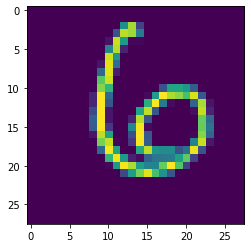

Indice de sobol du premier ordre:


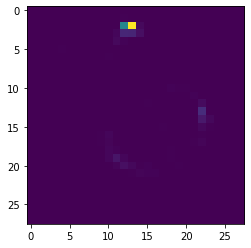

Number: 0
Image de X:


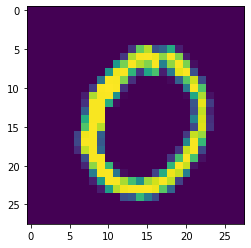

Indice de sobol du premier ordre:


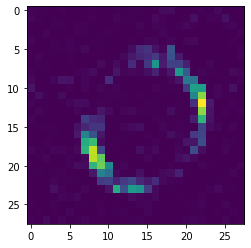

Number: 5
Image de X:


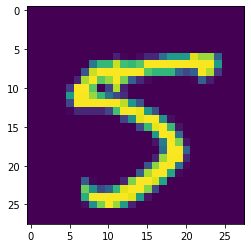

Indice de sobol du premier ordre:


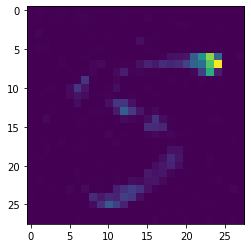

Number: 4
Image de X:


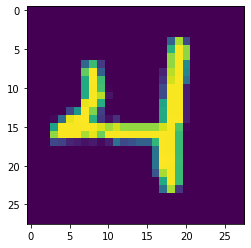

Indice de sobol du premier ordre:


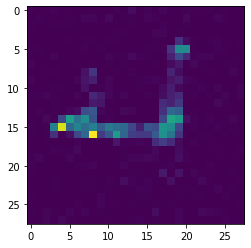

Number: 9
Image de X:


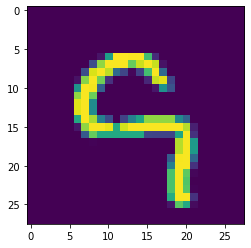

Indice de sobol du premier ordre:


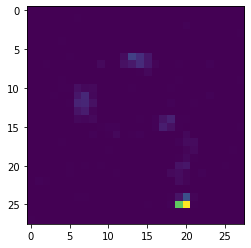

Number: 9
Image de X:


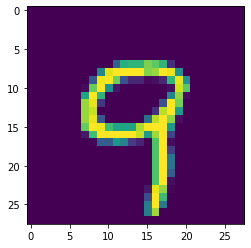

Indice de sobol du premier ordre:


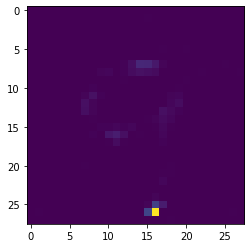

Number: 2
Image de X:


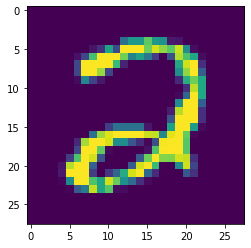

Indice de sobol du premier ordre:


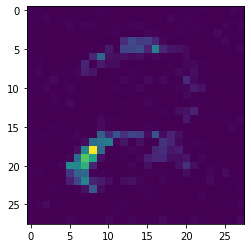

Number: 1
Image de X:


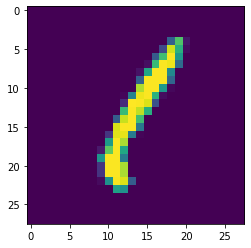

Indice de sobol du premier ordre:


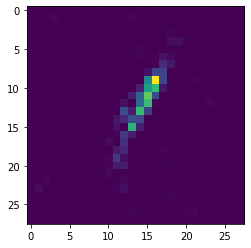

Number: 9
Image de X:


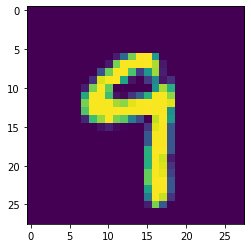

Indice de sobol du premier ordre:


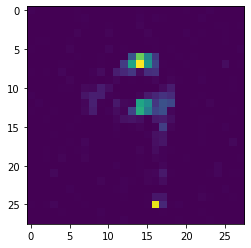

Number: 4
Image de X:


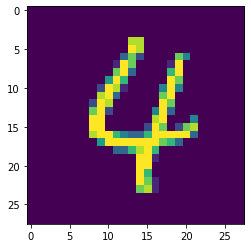

Indice de sobol du premier ordre:


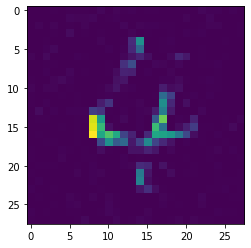

Number: 8
Image de X:


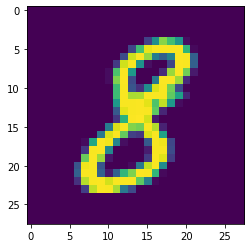

Indice de sobol du premier ordre:


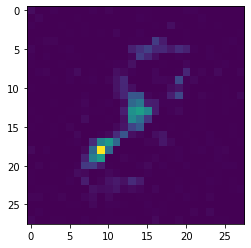

Number: 7
Image de X:


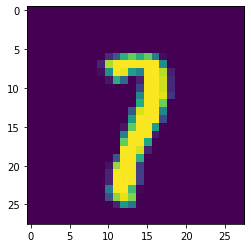

Indice de sobol du premier ordre:


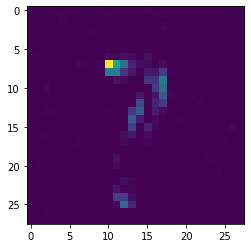

Number: 3
Image de X:


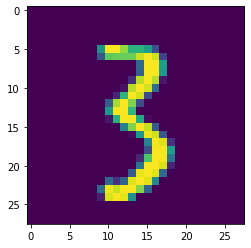

Indice de sobol du premier ordre:


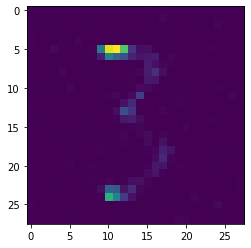

Number: 9
Image de X:


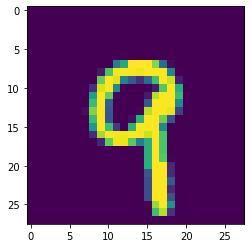

Indice de sobol du premier ordre:


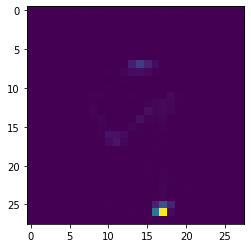

Number: 7
Image de X:


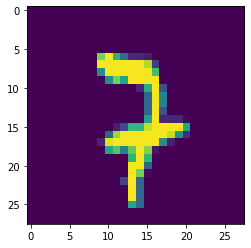

Indice de sobol du premier ordre:


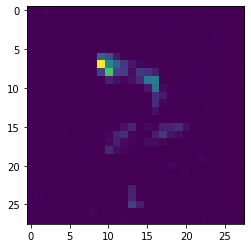

Number: 4
Image de X:


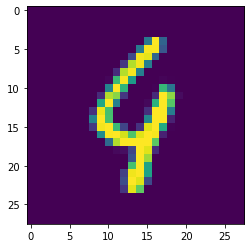

Indice de sobol du premier ordre:


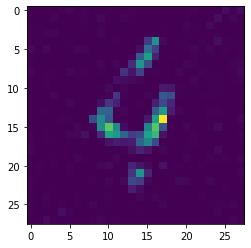

Number: 4
Image de X:


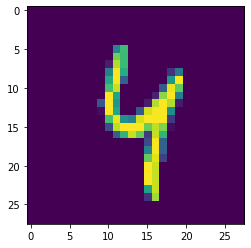

Indice de sobol du premier ordre:


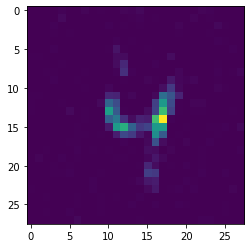

Number: 4
Image de X:


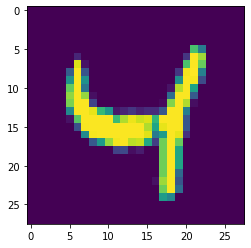

KeyboardInterrupt: 

In [168]:

for i in range(100,200):
    X=testDataset[i][0]
    y=torch.tensor(testDataset[i][1])
    print("Number: {}".format(y.item()))
    print("Image de X:")
    plt.imshow(X.squeeze().numpy())
    plt.show()
    model.eval()
    l_res=Sobol_premier_ordre(X,y,monte_num=1000,p=0.1)
    l_res_t=torch.tensor(l_res).view(28,28)
    print("Indice de sobol du premier ordre:")
    plt.imshow(l_res_t.squeeze().numpy())
    plt.show()

Indice de sobol de l'ordre total

In [169]:
def i_Sobol_numerateur_total(X,y,i,monte_num=100,p=0.5):
    model.eval()
    X=X.view(-1)
    X_expand=X.expand(monte_num,784)
    
    #Generate z
    Z0=torch.bernoulli(p*torch.ones(monte_num,784))
    Z0[:,i]=0
    Z1=torch.bernoulli(p*torch.ones(monte_num,784))
    Z1[:,i]=1
    Xi0=X*Z0
    Xi1=X*Z1
    V_list=(1-p)*F.softmax(model(Xi0),dim=1)[:,y]+p*F.softmax(model(Xi1),dim=1)[:,y]

    
    return V_list.var().item()
        

In [176]:
def Sobol_ordre_total(X,y,monte_num=100,p=0.5):
    model.eval()
    X=X.view(-1)
    X_expand=X.expand(monte_num,784)
    #calculate var(y)
    Z=torch.bernoulli(p*torch.ones(monte_num,784))
    Xp=X*Z
    V_y=F.softmax(model(Xp),dim=1).var(dim=0)[y]
    
    if V_y==0:
        print("V[y]=0")
        V_y=1
    else:
        V_y=V_y.item()
    #calculate indice de sobol for each pixel
    l_res=[]
    for i in range(784):
        
        l_res.append(1-i_Sobol_numerateur_total(X,y,i,monte_num,p)/V_y)
    return l_res

Number: 1
Image de X:


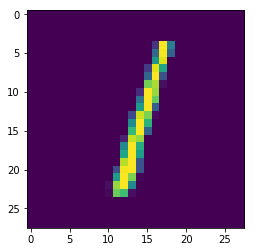

Indice de sobol de l'ordre total:


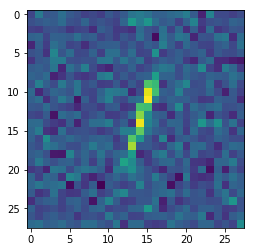

In [204]:
i=2
X=testDataset[i][0]
y=torch.tensor(testDataset[i][1])
print("Number: {}".format(y.item()))
print("Image de X:")
plt.imshow(X.squeeze().numpy())
plt.show()
model.eval()
l_res=Sobol_ordre_total(X,y,monte_num=100000,p=0.5)
l_res_t=torch.tensor(l_res).view(28,28)
print("Indice de sobol de l'ordre total:")
plt.imshow(l_res_t.squeeze().numpy())
plt.show()

Number: 0
Image de X:


/home/h86479/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


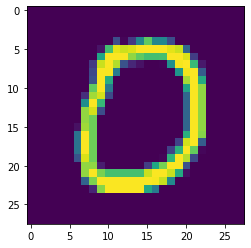

Indice de sobol de l'ordre total:


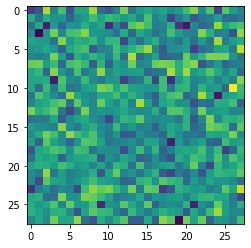

Number: 6
Image de X:


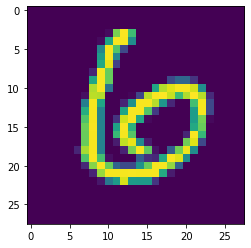

Indice de sobol de l'ordre total:


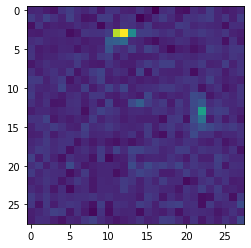

Number: 9
Image de X:


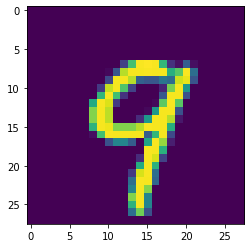

Indice de sobol de l'ordre total:


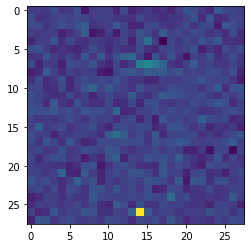

Number: 0
Image de X:


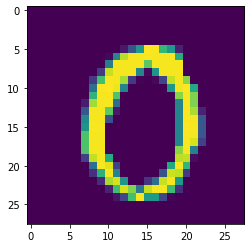

In [ ]:
for i in range(10,20):

    X=testDataset[i][0]
    y=torch.tensor(testDataset[i][1])
    print("Number: {}".format(y.item()))
    print("Image de X:")
    plt.imshow(X.squeeze().numpy())
    plt.show()
    model.eval()
    l_res=Sobol_ordre_total(X,y,monte_num=100000,p=0.5)
    l_res_t=torch.tensor(l_res).view(28,28)
    print("Indice de sobol de l'ordre total:")
    plt.imshow(l_res_t.squeeze().numpy())
    plt.show()